<font color='blue'> **step2_MF6Splitter** </font> 

In [1]:
import sys ; import flopy ; import matplotlib.pyplot as plt ; import numpy as np ; from flopy.mf6.utils import Mf6Splitter
from pathlib import Path; import warnings  ; warnings.filterwarnings("ignore", category=DeprecationWarning)  # pip install h5py

In [2]:
ref_data1  = Path("E:/15_REPOS/00_BETAMI/bin/Flopy_3099/03_RES_base_watershed")  # PETSc MPI paralel Mf6Splitter 08b(Flopy) docker, ...
ref_data2  = Path("E:/15_REPOS/00_BETAMI/bin/Flopy_3099/03.04_3099_watershed")   # Flopy
ref_data3  = Path("E:/15_REPOS/00_BETAMI/bin/Flopy_3099/04_RES_watershed_split/opt_split_models")  # Flopy     # 3099

sim_ws = Path("./03b_step02")  ; sim_ws.mkdir(exist_ok=True)  

In [3]:
parallel_dir = Path.cwd().joinpath("03b_step02/parallel")

In [4]:
ref_data = ref_data2 ;   base_sim = flopy.mf6.MFSimulation.load(sim_ws = ref_data, verbosity_level=0)   # base_dir
base_sim.set_sim_path(sim_ws) ; base_sim.write_simulation(silent=False)

In [5]:
nr_domains = 3  ; mfsplit = Mf6Splitter(base_sim)

In [6]:
gwf = base_sim.get_model()  ; nrow = gwf.modelgrid.nrow  ; ncol = gwf.modelgrid.ncol
use_metis = False
if use_metis:
    split_array = mfsplit.optimize_splitting_mask(nparts=nr_domains)
else:
    split_array = np.zeros((nrow, ncol), dtype=int)
    for irow in range(nrow):
        for icol in range(ncol): isub = np.floor(icol / (ncol / nr_domains)) ;  split_array[irow, icol] = isub

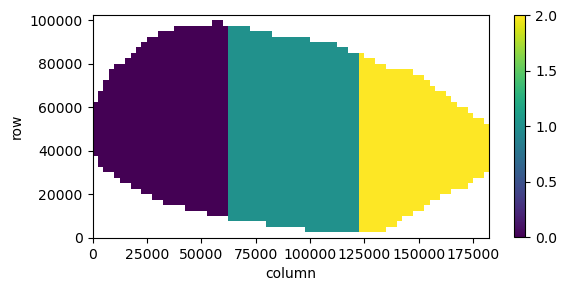

In [7]:
pmv = flopy.plot.PlotMapView(model=gwf, layer=0)            ; pa = pmv.plot_array(split_array)
pmv.plot_inactive(color_noflow="white") ; plt.ylabel("row") ; plt.xlabel("column") ; plt.colorbar(pa, shrink=0.6)

In [8]:
parallel_sim = mfsplit.split_model(split_array)

In [9]:
models = [parallel_sim.get_model(mname) for mname in parallel_sim.model_names]  # HPC file

In [10]:
partition_data = [[m.name, i] for i, m in enumerate(models)]   ; print(partition_data)

[['model_0', 0], ['model_1', 1], ['model_2', 2]]


In [11]:
hpc = flopy.mf6.ModflowUtlhpc(parallel_sim, partitions=partition_data)

Now write the simulation to disk. Also write the lookup table from the splitter so we can recombine the data to represent a single domain further below

In [12]:
parallel_sim.set_sim_path(parallel_dir)  ; parallel_sim.write_simulation()
mfsplit.save_node_mapping(parallel_dir / "mfsplit_node_mapping.json")

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing package model_0_model_1...
  writing package model_1_model_2...
  writing package sim.hpc...
  writing model model_0...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package rcha_0...
    writing package river...
    writing package gwd...
    writing package oc...
  writing model model_1...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package rcha_0...
    writing package river...
    writing package gwd...
    writing package oc...
  writing model model_2...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package rcha_0...
    writing package river...
    writing package gwd...
    writing package oc...


Plot the contours of the subdomains

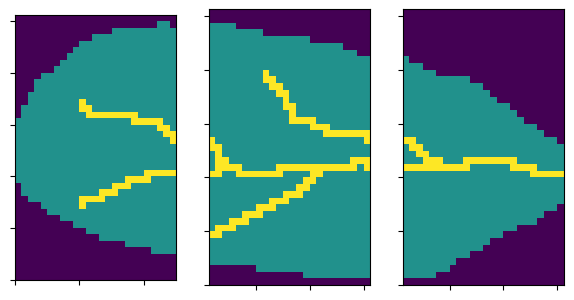

In [13]:
figheight = figwidth = 180 / 10 / 2.54  # inch
fig = plt.figure(figsize=(figwidth, 0.55 * figheight))

for i, m in enumerate(parallel_sim.model_names):
    ax = fig.add_subplot(1, nr_domains, i + 1)
    pmv = flopy.plot.PlotMapView(models[i])
    idomain = models[i].modelgrid.idomain
    pmv.plot_array(idomain[0], vmax=2)

    ax.set_xticklabels([])
    ax.set_yticklabels([])

Check if the model partitions are evenly split

In [14]:
for m in models:
    idomain = m.modelgrid.idomain
    print(f"Nr. of active cells in {m.name}:", np.count_nonzero(idomain))

Nr. of active cells in model_0: 3515
Nr. of active cells in model_1: 4200
Nr. of active cells in model_2: 2700
